## 1. Import Libraries/Dataset

In [131]:
# Import all the necessary files!
import os
import sys
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical
from keras.models import Sequential
from keras.regularizers import l2

from keras.constraints import maxnorm

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.optimizers import SGD
from os import getcwd

import numpy as np

import scipy

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

In [132]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1


In [133]:
# Selecting the dataset as CIFAR10

# load train and test dataset
def load_dataset():
  cifar10 = tf.keras.datasets.cifar10
	# load dataset
  (trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

x_train, y_train, x_test, y_test = load_dataset();

### 2. Data Visualization and augmentation

In [134]:
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 100
data_augmentation = False

In [135]:
# There are 10 image classes
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


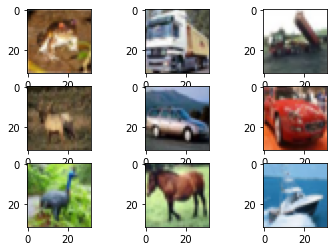

In [136]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(x_train[i])
# show the figure
plt.show()

In [137]:
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# prepare pixel data
x_train, x_test = prep_pixels(x_train, x_test)

The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

### 3. Model Building & 4. Model Compilation



* Model - 1

In [138]:
# dropout in the input layer with weight constraint
def define_model1():
	# create model
  model = Sequential()
  model.add(Flatten(input_shape=(32,32,3)))
  model.add(Dense(3000, activation='relu', kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.2))
  model.add(Dense(1000, activation='relu', kernel_regularizer=l2(0.001)))
  model.add(Dense(10, activation='sigmoid'))
  # Compile model
  sgd = SGD(lr=0.001, momentum=0.9)
  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  return model

In [139]:
# define model
model1 = define_model1()

### 5. Model Training


In [140]:
# fit model
history1 = model1.fit(x_train, y_train, epochs=30, batch_size=50, validation_data=(x_test, y_test), verbose=1)

Epoch 1/30
1000/1000 [==============================] - 11s 10ms/step - loss: 6.4645 - accuracy: 0.2922 - val_loss: 6.0641 - val_accuracy: 0.4067
Epoch 2/30
1000/1000 [==============================] - 10s 10ms/step - loss: 6.0171 - accuracy: 0.4064 - val_loss: 5.8162 - val_accuracy: 0.4277
Epoch 3/30
1000/1000 [==============================] - 10s 10ms/step - loss: 5.7756 - accuracy: 0.4306 - val_loss: 5.5878 - val_accuracy: 0.4535
Epoch 4/30
1000/1000 [==============================] - 10s 10ms/step - loss: 5.5499 - accuracy: 0.4548 - val_loss: 5.3947 - val_accuracy: 0.4686
Epoch 5/30
1000/1000 [==============================] - 10s 10ms/step - loss: 5.3718 - accuracy: 0.4615 - val_loss: 5.2814 - val_accuracy: 0.4553
Epoch 6/30
1000/1000 [==============================] - 10s 10ms/step - loss: 5.1834 - accuracy: 0.4784 - val_loss: 5.0874 - val_accuracy: 0.4702
Epoch 7/30
1000/1000 [==============================] - 10s 10ms/step - loss: 5.0087 - accuracy: 0.4911 - val_loss: 4.9119 -

In [141]:
print(model1)

### 6. Model Evaluation

In [142]:
# evaluate model
_, acc = model1.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 53.650


In [143]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # plot loss
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  # plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.show()
  plt.close()
	# save plot to file
	#filename = sys.argv[0].split('/')[-1]
	#plt.savefig(filename + '_plot.png')


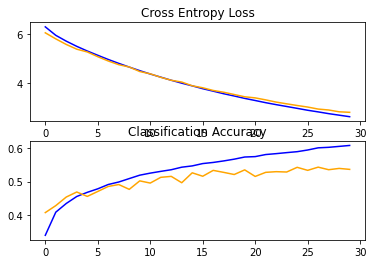

In [144]:
# learning curves
summarize_diagnostics(history1)

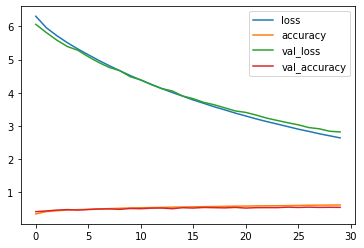

In [160]:
import pandas as pd
pd.DataFrame(history1.history).plot()

In [167]:
# Predict the values from the validation dataset
Y_pred = model1.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)  
Y_pred_classes[:5]

Y_true = np.argmax(y_test, axis=1)

In [168]:
print(Y_pred_classes[:4])
print(Y_true[:4])

[3 8 0 8]
[3 8 8 0]


In [169]:
from sklearn.metrics import confusion_matrix
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
confusion_mtx

array([[727,  26,  27,   6,  34,  11,  22,   5, 111,  31],
       [ 61, 677,  16,   4,  10,  12,  26,   6,  58, 130],
       [136,  16, 423,  29, 143,  74, 127,  13,  24,  15],
       [ 71,  28,  96, 163,  84, 236, 222,  17,  33,  50],
       [ 86,   9, 144,  11, 496,  42, 154,  23,  24,  11],
       [ 50,  13, 108,  76,  82, 480, 119,  21,  29,  22],
       [ 22,  12,  79,  12,  90,  39, 715,   3,  15,  13],
       [ 95,  16,  87,  26, 147,  98,  48, 425,  18,  40],
       [147,  58,  12,   3,  15,  15,  13,   3, 699,  35],
       [ 96, 163,  17,   9,  16,  27,  29,  18,  65, 560]])

In [170]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.49      0.73      0.58      1000
           1       0.67      0.68      0.67      1000
           2       0.42      0.42      0.42      1000
           3       0.48      0.16      0.24      1000
           4       0.44      0.50      0.47      1000
           5       0.46      0.48      0.47      1000
           6       0.48      0.71      0.58      1000
           7       0.80      0.42      0.55      1000
           8       0.65      0.70      0.67      1000
           9       0.62      0.56      0.59      1000

    accuracy                           0.54     10000
   macro avg       0.55      0.54      0.53     10000
weighted avg       0.55      0.54      0.53     10000



In [172]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

**incorrect prediction**

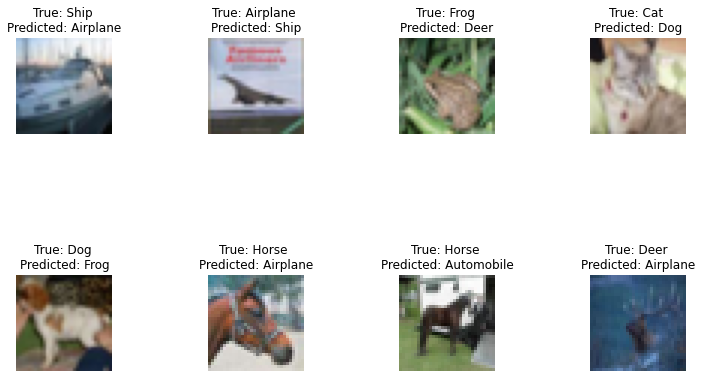

In [173]:
R = 2
C = 4
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

**Predicting new value using the trained model.**

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Text(0.5, 1.0, 'Predicted: Deer \nTrue Label: Deer')

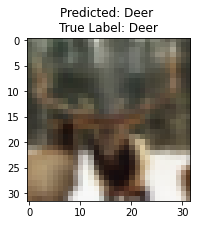

In [174]:
fig = plt.figure(figsize = (3,3))
test_image = np.expand_dims(x_test[26], axis=0)
test_result = model1.predict_classes(test_image)
plt.imshow(x_test[26])
dict_key = test_result[0]
plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key], labels[Y_true[26]]))

<h1>Alternate models with different parameters </h1></br>
1. Batch Size: Change the value of batch size in model training</br>
2. Optimiser: Use a different optimizer with the appropriate LR value

<h2>Model 2<h2>
<b>Batch Size : 64</b>

In [145]:
def define_model1():
	# create model
  model = Sequential()
  model.add(Flatten(input_shape=(32,32,3)))
  model.add(Dense(3000, activation='relu', kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.2))
  model.add(Dense(1000, activation='relu', kernel_regularizer=l2(0.001)))
  model.add(Dense(10, activation='sigmoid'))
  # Compile model
  sgd = SGD(lr=0.001, momentum=0.9)
  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  return model

In [146]:
# define model
model2 = define_model1()

In [147]:
# fit model
history2 = model2.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Epoch 1/30
782/782 [==============================] - 9s 11ms/step - loss: 6.5147 - accuracy: 0.2772 - val_loss: 6.1381 - val_accuracy: 0.3942
Epoch 2/30
782/782 [==============================] - 8s 11ms/step - loss: 6.0886 - accuracy: 0.3957 - val_loss: 5.9271 - val_accuracy: 0.4075
Epoch 3/30
782/782 [==============================] - 8s 11ms/step - loss: 5.8800 - accuracy: 0.4226 - val_loss: 5.7357 - val_accuracy: 0.4330
Epoch 4/30
782/782 [==============================] - 8s 11ms/step - loss: 5.6991 - accuracy: 0.4447 - val_loss: 5.5546 - val_accuracy: 0.4640
Epoch 5/30
782/782 [==============================] - 8s 11ms/step - loss: 5.5350 - accuracy: 0.4546 - val_loss: 5.4170 - val_accuracy: 0.4590
Epoch 6/30
782/782 [==============================] - 8s 11ms/step - loss: 5.3828 - accuracy: 0.4667 - val_loss: 5.2720 - val_accuracy: 0.4706
Epoch 7/30
782/782 [==============================] - 8s 11ms/step - loss: 5.2344 - accuracy: 0.4817 - val_loss: 5.1664 - val_accuracy: 0.4635

In [148]:
# evaluate model
_, acc = model2.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 53.730


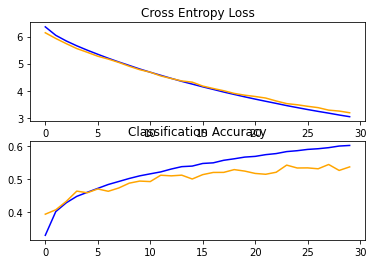

In [149]:
# learning curves
summarize_diagnostics(history2)

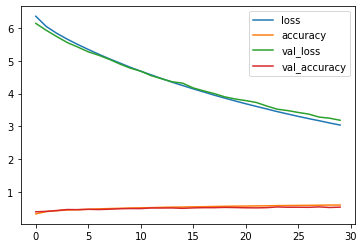

In [161]:
import pandas as pd
pd.DataFrame(history2.history).plot()

In [175]:
# Predict the values from the validation dataset
Y_pred = model2.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)  
Y_pred_classes[:5]

Y_true = np.argmax(y_test, axis=1)

In [176]:
print(Y_pred_classes[:4])
print(Y_true[:4])

[3 9 0 8]
[3 8 8 0]


In [177]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
confusion_mtx

array([[481,  21,  97,   4,  59,  24,  17,  39, 206,  52],
       [ 27, 606,  11,   5,  11,  19,  16,  28,  85, 192],
       [ 45,  12, 430,  20, 193, 118,  75,  59,  26,  22],
       [ 13,  15,  99, 135,  90, 343, 125,  82,  39,  59],
       [ 24,   6, 122,  14, 546,  70,  83,  88,  34,  13],
       [ 10,   7,  93,  50,  99, 558,  55,  74,  27,  27],
       [  4,  10,  62,  22, 150,  69, 608,  28,  20,  27],
       [ 22,   7,  55,  14,  96,  92,  18, 634,  19,  43],
       [ 51,  48,  24,   5,  32,  27,   4,  16, 738,  55],
       [ 27, 121,  14,   8,  17,  26,  18,  54,  78, 637]])

In [178]:
# print classification report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.68      0.48      0.56      1000
           1       0.71      0.61      0.65      1000
           2       0.43      0.43      0.43      1000
           3       0.49      0.14      0.21      1000
           4       0.42      0.55      0.48      1000
           5       0.41      0.56      0.48      1000
           6       0.60      0.61      0.60      1000
           7       0.58      0.63      0.60      1000
           8       0.58      0.74      0.65      1000
           9       0.57      0.64      0.60      1000

    accuracy                           0.54     10000
   macro avg       0.55      0.54      0.53     10000
weighted avg       0.55      0.54      0.53     10000



<b>Incorrect Classification</b>

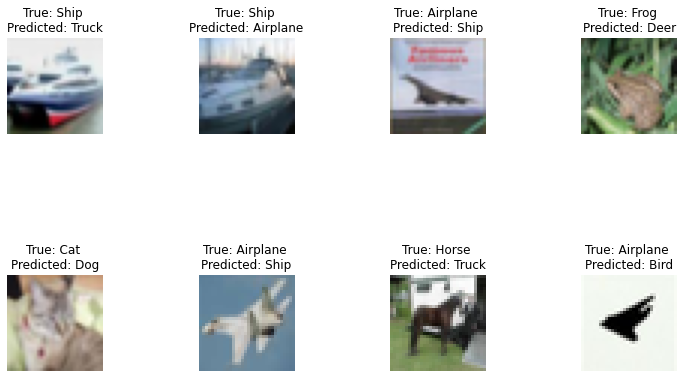

In [179]:
R = 2
C = 4
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

<h2>Model 3<h2>
<b>Optimizer = "adam"</b></br>
<b>Learning rate = .002</b>

In [155]:
def define_model3():
	# create model
  model = Sequential()
  model.add(Flatten(input_shape=(32,32,3)))
  model.add(Dense(3000, activation='relu', kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.2))
  model.add(Dense(1000, activation='relu', kernel_regularizer=l2(0.001)))
  model.add(Dense(10, activation='softmax'))
  # Compile model
  opt = keras.optimizers.Adam(learning_rate=0.0021)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [156]:
# define model
model3 = define_model3()

In [157]:
# fit model
history3 = model3.fit(x_train, y_train, epochs=30, batch_size=50, validation_data=(x_test, y_test), verbose=1)

Epoch 1/30
1000/1000 [==============================] - 11s 11ms/step - loss: 4.4195 - accuracy: 0.2341 - val_loss: 1.9799 - val_accuracy: 0.3364
Epoch 2/30
1000/1000 [==============================] - 11s 11ms/step - loss: 2.0552 - accuracy: 0.2911 - val_loss: 1.9000 - val_accuracy: 0.3349
Epoch 3/30
1000/1000 [==============================] - 11s 11ms/step - loss: 1.9995 - accuracy: 0.2851 - val_loss: 1.9070 - val_accuracy: 0.3284
Epoch 4/30
1000/1000 [==============================] - 11s 11ms/step - loss: 1.9559 - accuracy: 0.2981 - val_loss: 1.9305 - val_accuracy: 0.3153
Epoch 5/30
1000/1000 [==============================] - 11s 11ms/step - loss: 1.9544 - accuracy: 0.2942 - val_loss: 2.0351 - val_accuracy: 0.2608
Epoch 6/30
1000/1000 [==============================] - 11s 11ms/step - loss: 1.9468 - accuracy: 0.3045 - val_loss: 1.8710 - val_accuracy: 0.3366
Epoch 7/30
1000/1000 [==============================] - 11s 11ms/step - loss: 1.9444 - accuracy: 0.3018 - val_loss: 1.9366 -

In [158]:
# evaluate model
_, acc = model3.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 30.320


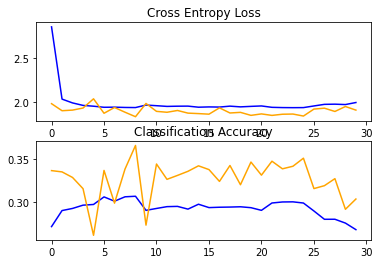

In [159]:
# learning curves
summarize_diagnostics(history3)

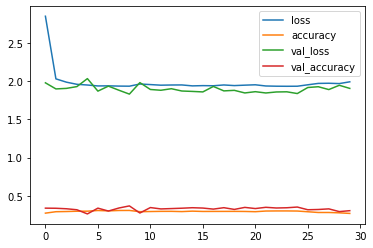

In [163]:
import pandas as pd
pd.DataFrame(history3.history).plot()

In [180]:
# Predict the values from the validation dataset
Y_pred = model3.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)  
Y_pred_classes[:5]

Y_true = np.argmax(y_test, axis=1)

In [181]:
print(Y_pred_classes[:4])
print(Y_true[:4])

[5 9 8 8]
[3 8 8 0]


In [182]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
confusion_mtx

array([[138,  45,   6,  25,  16, 102,  54,  68, 376, 170],
       [  8, 464,   2,  49,  11,  68, 100,  41,  60, 197],
       [ 59,  30,   5,  48, 126, 163, 372,  83,  78,  36],
       [  8,  67,   7,  48,  73, 362, 311,  66,  27,  31],
       [ 23,  26,   2,  41, 195, 134, 444,  73,  20,  42],
       [  6,  33,   5,  45,  74, 475, 261,  58,  26,  17],
       [  5,  46,   6,  33, 117, 189, 554,  34,   4,  12],
       [ 18,  40,   0,  28, 113, 140, 225, 293,  26, 117],
       [ 45, 113,   0,  25,   1, 130,  25,  29, 410, 222],
       [  8, 288,   0,  17,   9,  37,  76,  65,  50, 450]])

In [183]:
# classification report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.43      0.14      0.21      1000
           1       0.40      0.46      0.43      1000
           2       0.15      0.01      0.01      1000
           3       0.13      0.05      0.07      1000
           4       0.27      0.20      0.22      1000
           5       0.26      0.47      0.34      1000
           6       0.23      0.55      0.32      1000
           7       0.36      0.29      0.32      1000
           8       0.38      0.41      0.39      1000
           9       0.35      0.45      0.39      1000

    accuracy                           0.30     10000
   macro avg       0.30      0.30      0.27     10000
weighted avg       0.30      0.30      0.27     10000



<b> Incorrect Classification </b>

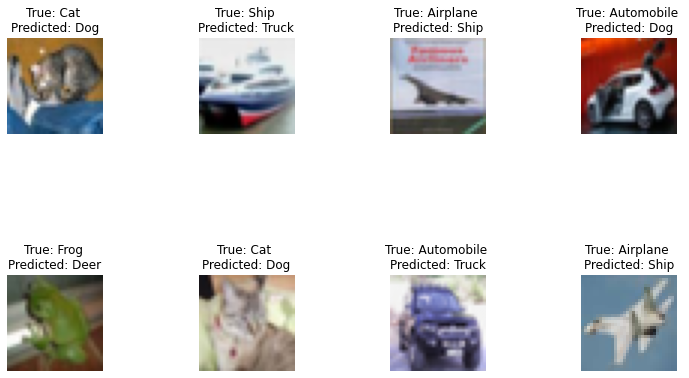

In [184]:
R = 2
C = 4
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)